<a href="https://colab.research.google.com/github/bodadaniel/Clustering/blob/main/clustering_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [95]:
import math
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import sklearn.metrics as sklearn_metrics
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles, make_moons, load_digits
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import MaxAbsScaler

## Data

In [86]:
def create_data(n_samples = [400, 300, 300]):
  """ Create data with certain shape of clusters and a number of a sample """
  blobs_x, blobs_y = make_blobs(n_samples = n_samples[0], centers = 2, cluster_std = 1.3, random_state = 333)
  circle_x, circle_y = make_circles(n_samples = n_samples[1], noise = 0.09, factor = 0.3, random_state = 333)
  moon_x, moon_y = make_moons(n_samples = n_samples[2], noise = 0.07, random_state = 333)

  x = np.concatenate([blobs_x, 3 * moon_x + 9, 3 * circle_x - 13])
  x[:,1] = x[:,1] / 7

  rnd = np.random.default_rng(seed = 333)
  rnd.shuffle(x)
  return x

X = create_data()

##Vizualise

<ipython-input-87-80e89c27638d>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*x.T, s = 10, c = labels, cmap = cmap)


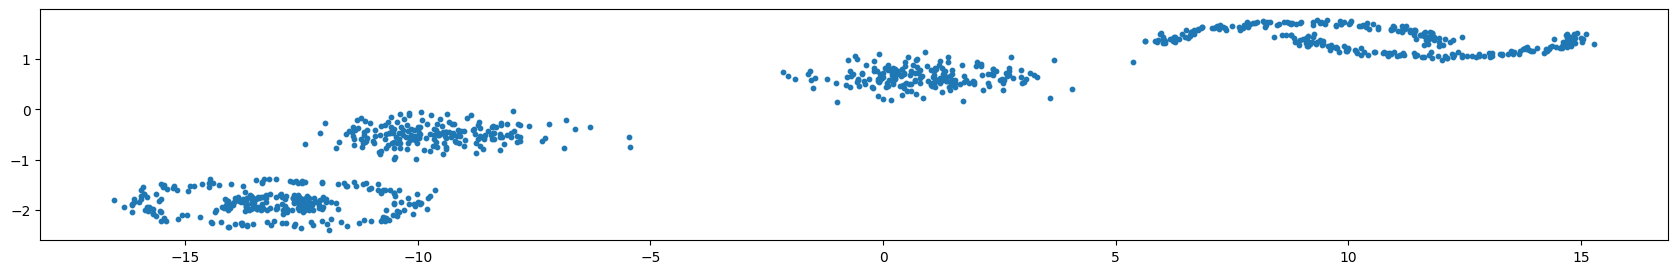

In [87]:
def visualise_clusters(x, labels = None, cmap = 'viridis'):
    """ Visualize data in R{2} """
    plt.figure(figsize = (21, 3))
    plt.scatter(*x.T, s = 10, c = labels, cmap = cmap)
    plt.show()

visualise_clusters(X)

## Scoring

In [88]:
def silhouette_score(X, labels):
  """Wrapper function of Scikit-learn's silhouette_score. The only difference is it doesn't throw an error where there is only one label."""

  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.silhouette_score(X, labels)

def bic_score(X, labels):
  """ BIC score for the goodness of fit of clusters. """

  n_points = len(labels)
  n_clusters = len(set(labels))
  n_dimensions = X.shape[1]

  n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

  loglikelihood = 0
  for label_name in set(labels):
    X_cluster = X[labels == label_name]
    n_points_cluster = len(X_cluster)
    centroid = np.mean(X_cluster, axis=0)
    variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
    loglikelihood += \
      n_points_cluster * np.log(n_points_cluster) \
      - n_points_cluster * np.log(n_points) \
      - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * variance) \
      - (n_points_cluster - 1) / 2

  bic = loglikelihood - (n_parameters / 2) * np.log(n_points)

  return bic

## Hyperparamter space

In [89]:
eps = np.arange(0.01, 0.6, 0.05)
min_samples = np.arange(2, 10, 1)
hyperpars = {i: pars for i, pars in enumerate([[x,y] for x in eps for y in min_samples]) }

## Result

In [90]:

def scores(X, hyperpars):
  """ Dict of scores """

  score = {'silhouette_score' : [],
          'bic_score' : []}

  for i, pars_i in enumerate(hyperpars.values()):
    dbsc = DBSCAN(eps=pars_i[0], min_samples=pars_i[1])
    clusters = dbsc.fit_predict(X)
    labels = dbsc.labels_
    score['silhouette_score'].append(silhouette_score(X, labels))
    score['bic_score'].append(bic_score(X, labels))
    #break

  return score

score = scores(X, hyperpars)

## Best ones

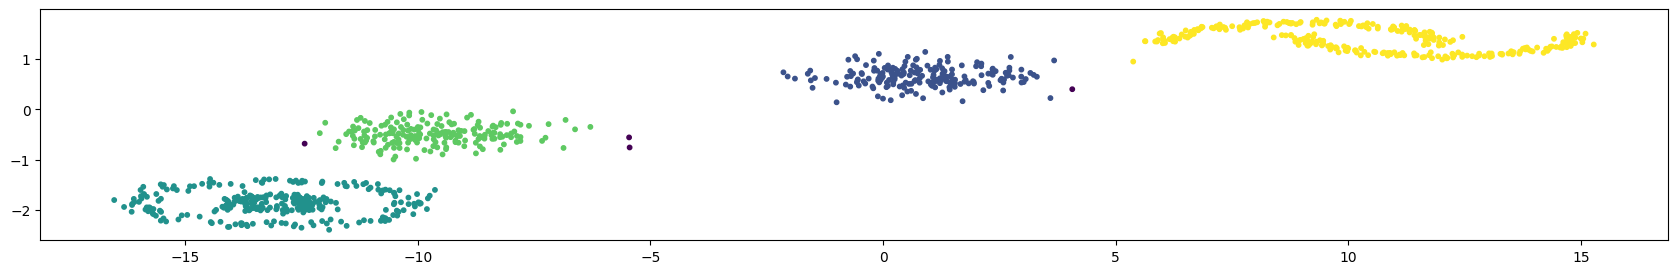

pars 92: [0.56, 6] 
silhouette_score: 0.6095433513443101


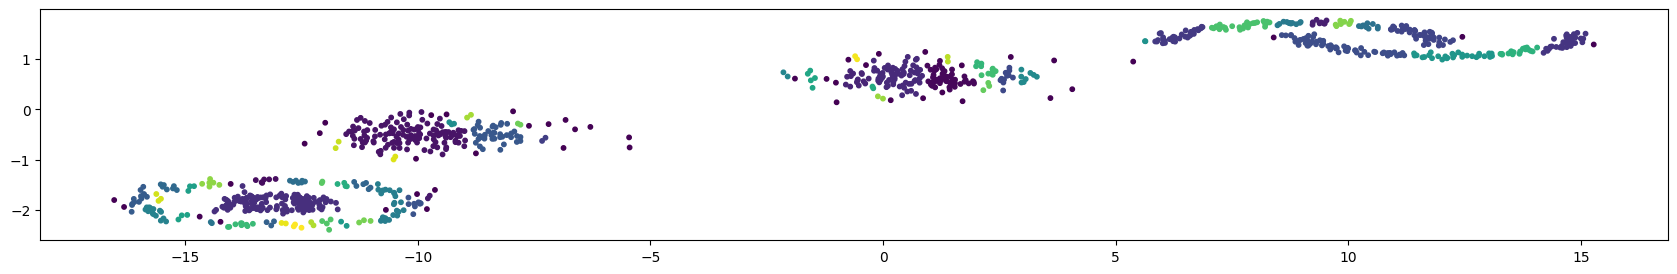

pars 24: [0.16000000000000003, 2] 
bic_score: -4300.610259199635


In [91]:

def show_best(score, score_in, X):
  """ Choose best models based on different scoring functions """
  pars_i = hyperpars[np.nanargmax(score[score_in])]
  dbsc = DBSCAN(eps=pars_i[0], min_samples=pars_i[1])
  clusters = dbsc.fit_predict(X)
  labels = dbsc.labels_
  visualise_clusters(X, labels)
  print(f'pars {np.nanargmax(score[score_in])}:', pars_i,f'\n{score_in}:', np.nanmax(score[score_in]) )

show_best(score, 'silhouette_score', X)
show_best(score, 'bic_score', X)

## With transformation!!!

In [92]:
X = MaxAbsScaler().fit_transform(X)

In [93]:
score = scores(X, hyperpars)

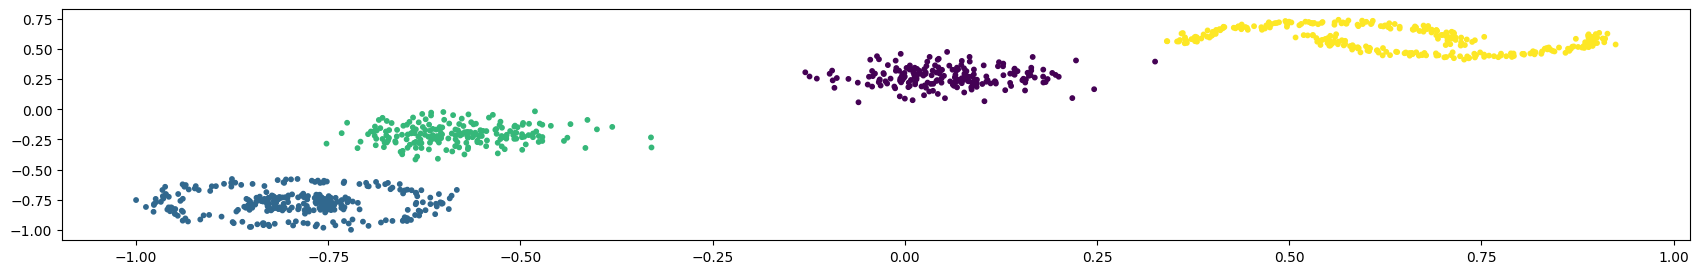

pars 16: [0.11, 2] 
silhouette_score: 0.7227100111467499


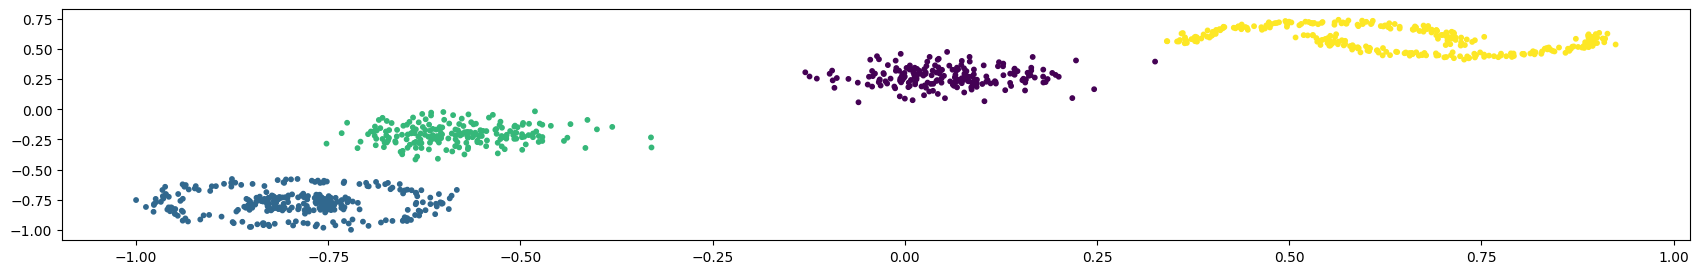

pars 16: [0.11, 2] 
bic_score: 249.31762946937823


In [94]:
show_best(score, 'silhouette_score', X)
show_best(score, 'bic_score', X)

# On "real" labeled data

In [19]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [ ]:
print(digits.DESCR)

In [18]:
data = digits.data
target = digits.target

In [48]:
pd.Series(target).value_counts()

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

## TSNE for vizualization

In [43]:
data_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=31).fit_transform(data)
data.shape, data_embedded.shape

((1797, 64), (1797, 2))

<ipython-input-3-80e89c27638d>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*x.T, s = 10, c = labels, cmap = cmap)


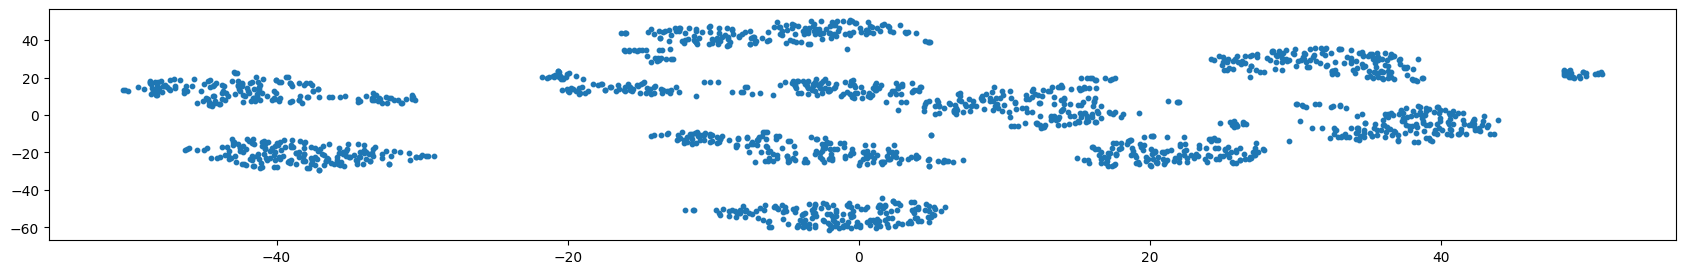

In [44]:
visualise_clusters(data_embedded)

## Tuning 1

In [59]:
score = scores(data_embedded, hyperpars)

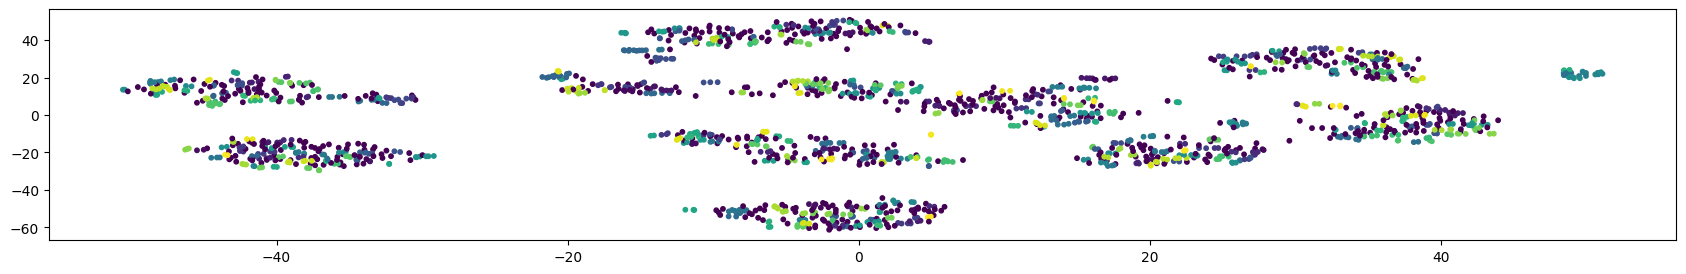

pars 88: [0.56, 2] 
silhouette_score: 0.07158279418945312


In [60]:
show_best(score, 'silhouette_score', data_embedded)

##Transformation and tuning 2

In [61]:
normed_data_embedded = MaxAbsScaler().fit_transform(data_embedded)

<ipython-input-3-80e89c27638d>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*x.T, s = 10, c = labels, cmap = cmap)


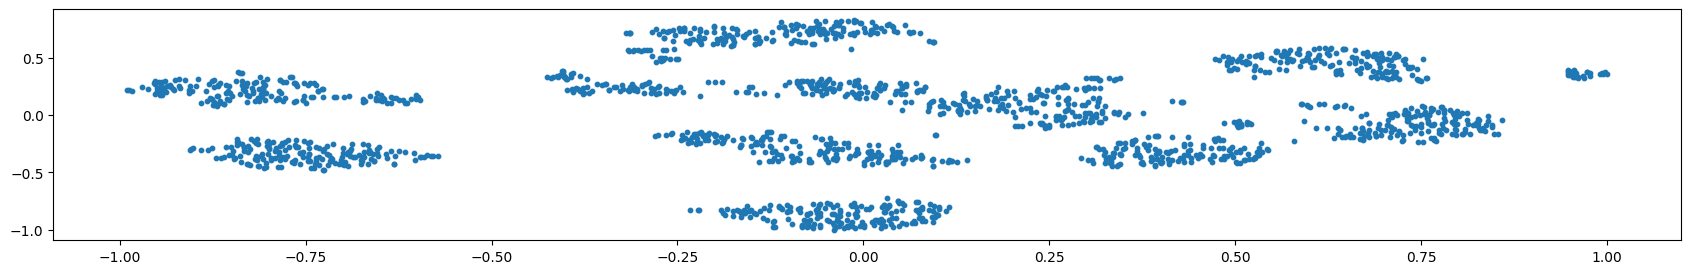

In [62]:
visualise_clusters(normed_data_embedded)

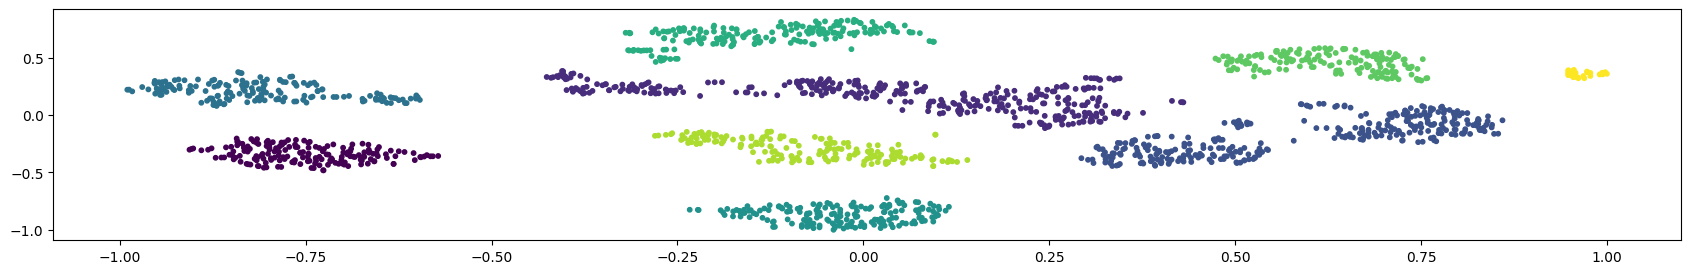

pars 16: [0.11, 2] 
silhouette_score: 0.5742663741111755


In [63]:
score = scores(normed_data_embedded, hyperpars)
show_best(score, 'silhouette_score', normed_data_embedded)

##Measure accuracy

In [78]:
labels = DBSCAN(eps=0.11, min_samples=2).fit_predict(normed_data_embedded)
sum(labels == target) / len(target)

0.18530884808013356

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


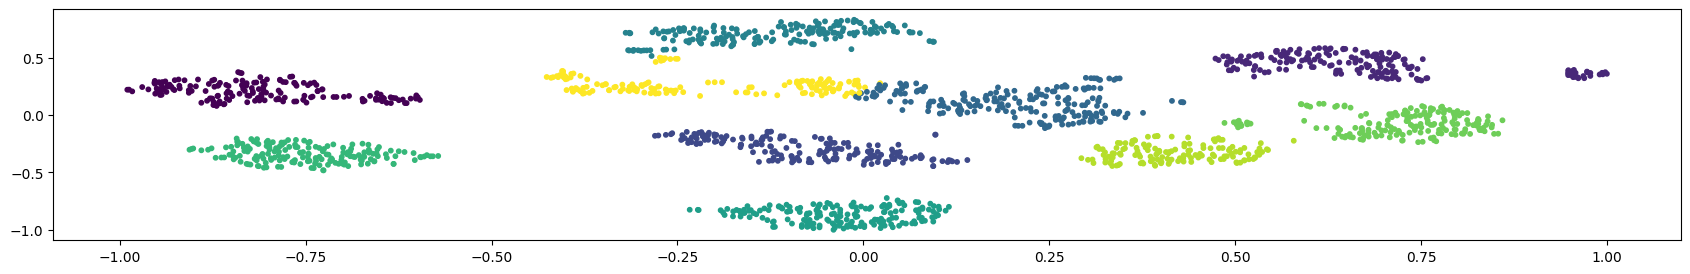

0.03394546466332777

In [71]:
k_means_clusters = KMeans(n_clusters = 10).fit_predict(normed_data_embedded)
visualise_clusters(normed_data_embedded, k_means_clusters)
sum(k_means_clusters == target) / len(target)